### Cats vs Dogs classifier using Transfer Learning

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Importing the required libraries and downloading the dataset ZIP archive from the given URL and saving it in the specified directory.

In [2]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
data_file_name = "catdogs.zip"
download_dir = '/tmp/'
urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

Checking if the dataset has the expected number of examples.

In [3]:
print("Number of cat images = ", len(os.listdir('/tmp/PetImages/Cat/')))
print("Number of dog images = ", len(os.listdir('/tmp/PetImages/Dog/')))

Number of cat images =  12501
Number of dog images =  12501


Creating folders to store training and testing data

In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

Now we will split the data into test set and the training set

In [5]:
from shutil import copyfile

def split_data(source, training, testing, split_size):
  files = []
  for filename in os.listdir(source):
    file = source + filename
    if os.path.getsize(file) > 0:
      files.append(filename)
    else:
      print(filename + " is of zero length, so ignoring.")

  training_length = int(len(files) * split_size)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[training_length:]

  for filename in training_set:
    this_file = source + filename
    destination = training + filename
    copyfile(this_file, destination)

  for filename in testing_set:
    this_file = source + filename
    destination = testing + filename
    copyfile(this_file, destination)

cat_source_dir = '/tmp/PetImages/Cat/'
training_cats_dir = '/tmp/cats-v-dogs/training/cats/'
testing_cats_dir = '/tmp/cats-v-dogs/testing/cats/'
dog_source_dir = '/tmp/PetImages/Dog/'
training_dogs_dir = '/tmp/cats-v-dogs/training/dogs/'
testing_dogs_dir = '/tmp/cats-v-dogs/testing/dogs/'

split_size = 0.9
split_data(cat_source_dir, training_cats_dir, testing_cats_dir, split_size)
split_data(dog_source_dir, training_dogs_dir, testing_dogs_dir, split_size)

666.jpg is of zero length, so ignoring.
11702.jpg is of zero length, so ignoring.


Now we will check if the training set and testing set are of expected lengths or not

In [6]:
print("Number of training cat images ", len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print("Number of training dog images ", len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print("Number of testing cat images ", len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print("Number of testing dog images ", len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

Number of training cat images  11250
Number of training dog images  11250
Number of testing cat images  1250
Number of testing dog images  1250


Now, by employing ImageDataGenerator for data augmentation, operations such as rotation and flipping can generate more diverse training data, ultimately aiding the model in better generalization during the training process.

In [7]:
training_dir = '/tmp/cats-v-dogs/training/'
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')
train_generator = train_datagen.flow_from_directory(training_dir,
                                                    batch_size = 100,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

validation_dir = '/tmp/cats-v-dogs/testing/'
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size = 100,
                                                              class_mode = 'binary',
                                                              target_size = (150, 150))

Found 22499 images belonging to 2 classes.
Found 2499 images belonging to 2 classes.


In [8]:
total_training_samples = train_generator.n
print("Total training samples after data augmentation = ", total_training_samples)

total_testing_samples = validation_generator.n
print("Total testing samples after data augmentation = ", total_testing_samples)

Total training samples after data augmentation =  22499
Total testing samples after data augmentation =  2499


Using InceptionV3 model as transfer learning model, loading the pre-trained weights of the model. Freezing the existing layers so that they are not trained in this downstream task with cats and dogs data.

In [9]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

# Load pre-trained weights
pre_trained_model.load_weights(weights_file)

# Freeze the layers
for layer in pre_trained_model.layers:
  layer.trainable = False

# Pre-trained model summary()
last_layer = pre_trained_model.get_layer('mixed7')
print('Last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Last layer output shape:  (None, 7, 7, 768)


Adding layers that will be trained on cats and dogs data. The following layers are added -
* Flatten - This will take the output of the last layer and flatten it to a vector
* Dense - We will add a dense layer with relu activation
* Dense - We will add a dense layer with the sigmoid activation. The sigmoid activation will scale the output to range from 0 to 1 and will interpret the output as a prediction between two categories (dogs and cats in this case)
Then create the model object.

In [10]:
# Flatten the output layer to one dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation = 'relu')(x)

# Adding the final sigmoid layer for classification
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)

Visualising the architecture of the above model using the Keras 'plot_model' function which generates a graphical representation of the model's architecture.

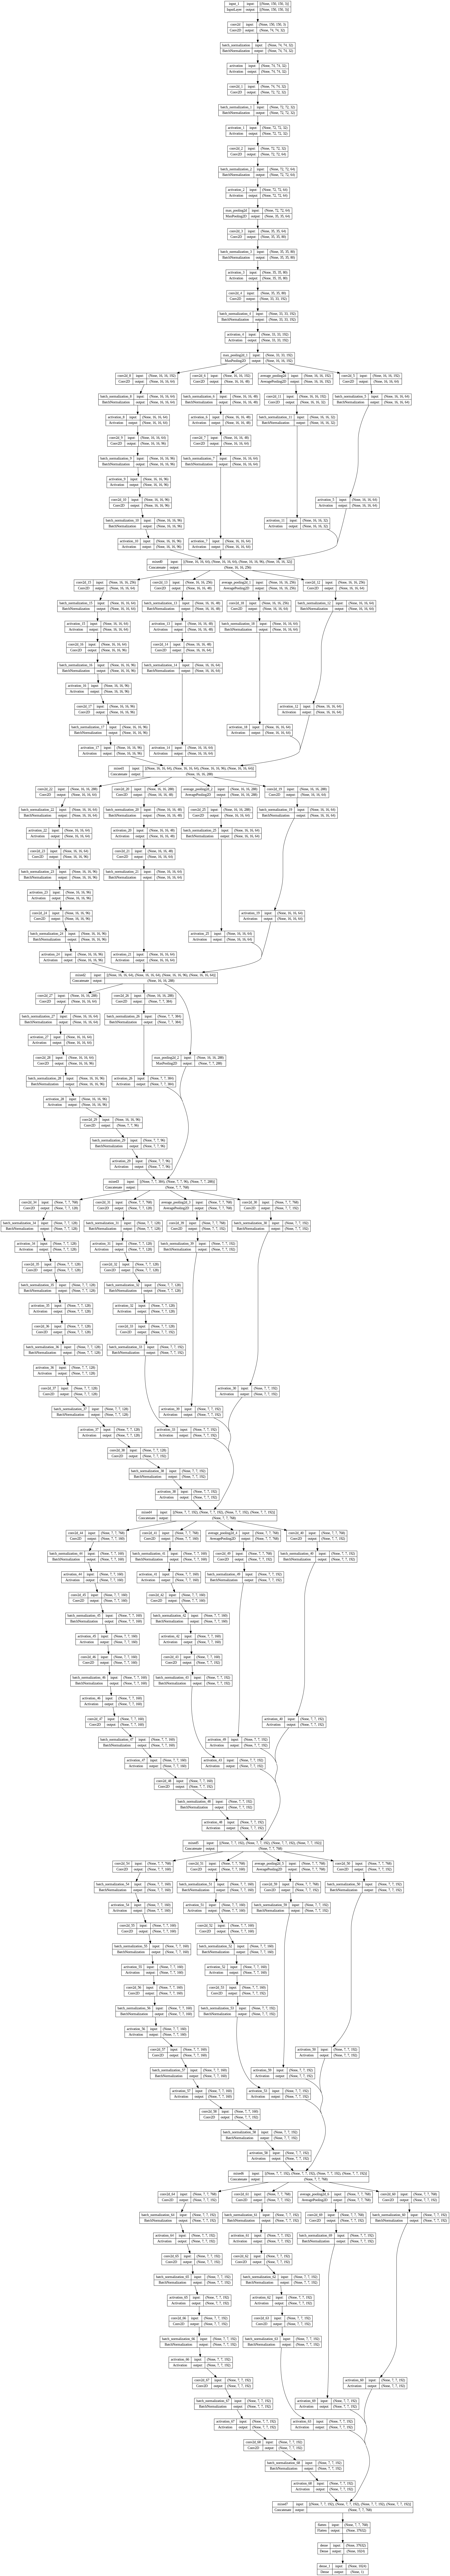

In [11]:
from keras.utils import plot_model

# Visualize the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Now we will train the model using model.fit

In [12]:
# compile the model
model.compile(optimizer = RMSprop(lr = 0.0001),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

# train the model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 10,
                    verbose = 1)

Epoch 1/10
206/225 [==========================>...] - ETA: 13s - loss: 0.5964 - acc: 0.8930

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


225/225 [==============================] - 174s 713ms/step - loss: 0.5604 - acc: 0.8957 - val_loss: 0.0685 - val_acc: 0.9708
Epoch 2/10
225/225 [==============================] - 159s 703ms/step - loss: 0.1502 - acc: 0.9369 - val_loss: 0.0686 - val_acc: 0.9780
Epoch 3/10
225/225 [==============================] - 162s 719ms/step - loss: 0.1398 - acc: 0.9420 - val_loss: 0.0608 - val_acc: 0.9796
Epoch 4/10
225/225 [==============================] - 158s 703ms/step - loss: 0.1294 - acc: 0.9454 - val_loss: 0.0583 - val_acc: 0.9808
Epoch 5/10
225/225 [==============================] - 156s 694ms/step - loss: 0.1263 - acc: 0.9464 - val_loss: 0.0561 - val_acc: 0.9776
Epoch 6/10
225/225 [==============================] - 155s 690ms/step - loss: 0.1220 - acc: 0.9499 - val_loss: 0.0577 - val_acc: 0.9776
Epoch 7/10
225/225 [==============================] - 154s 686ms/step - loss: 0.1195 - acc: 0.9519 - val_loss: 0.0667 - val_acc: 0.9764
Epoch 8/10
225/225 [==============================] - 149s 

Visualizing the training and validation accuracy

<Figure size 640x480 with 0 Axes>

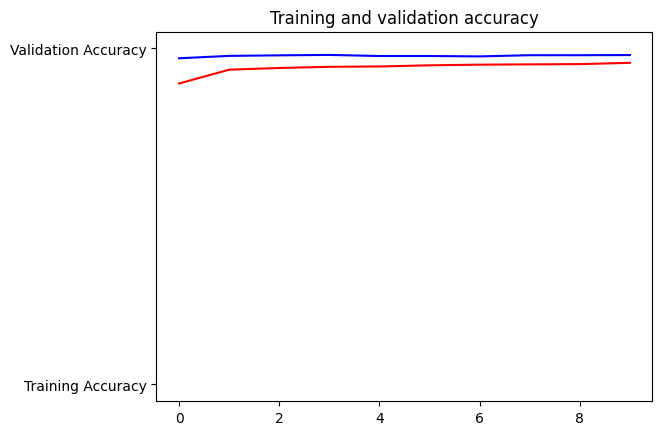

<Figure size 640x480 with 0 Axes>

In [13]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

Testing the model on a randomly uploaded image

In [15]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = load_img(path, target_size = (150, 150))
  x = img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis = 0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes[0])
  if(classes[0] > 0.5):
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving ri2.jpeg to ri2 (1).jpeg
Saving ri3.jpeg to ri3 (1).jpeg
Saving ri6.jpeg to ri6 (1).jpeg
1/1 [==============================] - 0s 24ms/step
[0.9547355]
ri2 (1).jpeg is a dog
1/1 [==============================] - 0s 23ms/step
[0.9401591]
ri3 (1).jpeg is a dog
1/1 [==============================] - 0s 31ms/step
[2.651354e-05]
ri6 (1).jpeg is a cat
